#Transfer Learning with TensorFlow Part 2: Fine-tuning

in the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [64]:
# check if we're using a GPU
!nvidia-smi

Fri Dec 16 07:45:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   4978MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions
in previous notebooks, we've created a bunch of helper functions, now we could rewrite them all,however, this is tedious.

In [65]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-16 07:45:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-16 07:45:22 (111 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [66]:
# Import helper function we've going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** if you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper function.

## Let's get some data
this time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [67]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-12-16 07:45:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 142.251.163.128, 142.251.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2022-12-16 07:45:23 (164 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [68]:
# check out how many images and subdirectories in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [69]:
# create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [70]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [72]:
# check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [73]:
# see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [6.17797012e+01 2.35130825e+01 2.84939880e+01]
   [6.57669601e+01 2.64098167e+01 3.24812469e+01]
   [7.06980591e+01 3.13409157e+01 3.74123459e+01]]

  [[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [6.60267334e+01 2.33893223e+01 2.96587009e+01]
   [6.36253014e+01 2.16967278e+01 2.39556122e+01]
   [6.51725311e+01 2.44461594e+01 2.53868160e+01]]

  [[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [9.35834503e+01 4.33915138e+01 5.23244705e+01]
   [8.93768768e+01 3.99483070e+01 4.35633545e+01]
   [8.65586624e+01 4.02101440e+01 3.86211281e+01]]

  ...

  [[1.16357208e+02 1.23572083e+01 1.97857361e+01]
   [1

## Model 0: Buliding a transfer learning model using the Keras Function
The sequential API is stright-forward, it runs our layers in sequential order.

In [74]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying per-trained patterns aren't update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3),name="input_layer")

# 4. if using a model like Resnet50v2 you will need to normalize input (you don't have to for EfficintNet(s))
# x = tf.keras.layers.experimental.preproccessing.Rescaling(1./255)

# 5. pass the input to the base_model
x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

# 6. Average pool the output of the base model (aggreate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after GlobalAveragepooling2D:{x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. combine the input with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221216-074530
Epoch 1/5
24/24 [==============================] - 17s 243ms/step - loss: 1.8812 - accuracy: 0.4360 - val_loss: 1.2633 - val_accuracy: 0.7467
Epoch 2/5
24/24 [==============================] - 4s 165ms/step - loss: 1.1041 - accuracy: 0.7387 - val_loss: 0.8342 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 5s 174ms/step - loss: 0.8055 - accuracy: 0.8253 - val_loss: 0.6537 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 4s 158ms/step - loss: 0.6485 - accuracy: 0.8467 - val_loss: 0.5967 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 4s 166ms/step - loss: 0.5586 - accuracy: 0.8747 - val_loss: 0.5390 - val_accuracy: 0.8717


In [75]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5619 - accuracy: 0.8596


[0.5618700981140137, 0.8596000075340271]

In [76]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 tf.math.truediv_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [77]:
# how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [78]:
# how about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


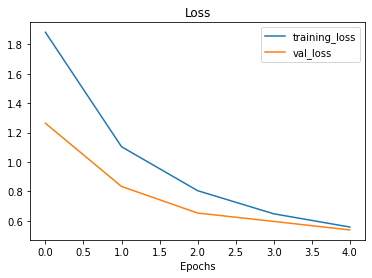

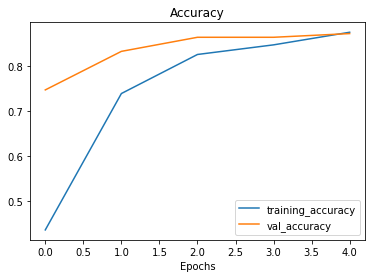

In [79]:
# check out our models training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model 

let's demonstrate the Global Average Pooling 2D layer...

we have a tensor after our model goes through `base_model`, it turns into(None,7,7,1280).

but then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

lets use a similar shaped tensor of (1,4,4,3) and then pass it to GOlbalAveragePooling2D.

In [80]:
# define the inout shape
input_shape = (1,4,4,3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor: \n{input_tensor} \n")

# pass the random tensor through a global average pooling 2D layer
global_average_pool_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pool_tensor}\n")

# check the shape of the different tensor 
print(f"shape of input tensor: {input_tensor.shape}")
print(f"shape of Global Average Pooled 2D tensor : {global_average_pool_tensor.shape}")

random input tensor: 
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
shape of Global Average Pooled 2D tensor : (1, 3)


In [81]:
# let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

try to do the same with the above two calls but this time use `GlobalMaxPool2D` ... and see what happens.

> 🔑**Note**: one of the reasons feature extraction transfer learning is named how it is beacause what often happen is pretrained model output a **feature vector**(a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is output of the `tf.keras.layers.GlobalAverage.Pooling2D()` layer) which can then be used to extract pattern out of for our own specifc problem.

## Running a series of transfer learning experiments 

we've seen the incredible results transfer learning can get with only 10% of the training data , but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data agumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tining transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note** throughout all experiments the same test dataset will be used to evaluate our model... thiis ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [82]:
# Download the unzip -preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-12-16 07:46:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.250.73.240, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  71.9MB/s    in 1.8s    

2022-12-16 07:46:21 (71.9 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [83]:
#create training and test dirs 
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [84]:
# how many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [85]:
# setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
     

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model 
to add data augmentation right our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`


off the top our of head , after reading the docs, the benefit of using data agumentation inside the model are:

* preprocessing of images (agumenting them) happens on the GPU (much faster) rather than CPU.
* image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [86]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flipping , rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1./255) # keep for models like ResNeet50v2 but EfficientNet's having rescaling bulit-in
],name="data_augmentation")


### Visualize our data agumentation layer (and see what happens to our data)

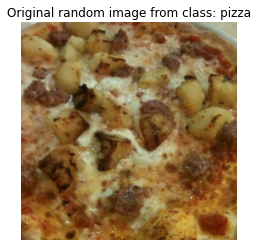

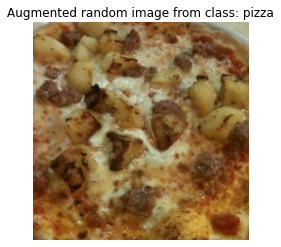

In [87]:


# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
     

## Model 1:Feature extraction transfer learning on 1% of the data with data augmentation

In [88]:
# setup input shape and base model, freezing the base model layer
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after augmentation) and don't train it 
x = base_model(x, training=False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_avereagepooling_layer")(x)

#put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221216-074626
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4244 - accuracy: 0.0857 - val_loss: 2.2470 - val_accuracy: 0.1826
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1713 - accuracy: 0.1857 - val_loss: 2.1226 - val_accuracy: 0.2566
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9639 - accuracy: 0.4000 - val_loss: 2.0163 - val_accuracy: 0.3141
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7977 - accuracy: 0.5857 - val_loss: 1.9159 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6323 - accuracy: 0.6429 - val_loss: 1.8247 - val_accuracy: 0.4424


In [89]:
# evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.8139 - accuracy: 0.4556


[1.813888430595398, 0.45559999346733093]

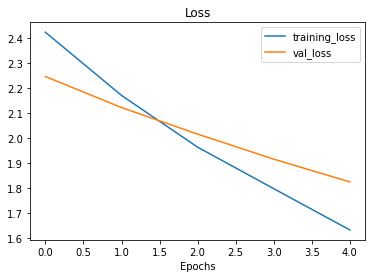

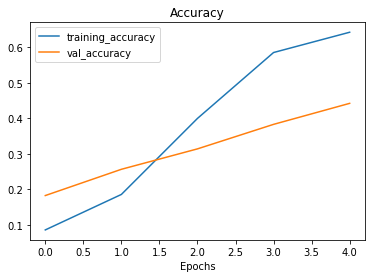

In [90]:
# how do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [91]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [92]:
# set data inputs
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [93]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [94]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### creating a ModelCheckpoint callback

the Modelcheckpoint callback internediately saves our model (the full model or just the weights) during training. this is useful so we can come and start we left off .

In [95]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt" # ck check pt point  

# create a Modelcheckpoint callback that save the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",# save every epoch
                                                         verbose=1)

### Fit the model saving checkpoint every epoch


In [96]:
initial_epochs = 5 
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221216-074708
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9542 - accuracy: 0.3787
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 16s 444ms/step - loss: 1.9542 - accuracy: 0.3787 - val_loss: 1.3941 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2775 - accuracy: 0.7027
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 8s 328ms/step - loss: 1.2775 - accuracy: 0.7027 - val_loss: 0.9624 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0019 - accuracy: 0.7627
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 8s 311ms/step - loss: 1.0019 - accuracy: 0.7627 - val_loss: 0.7660 - val_accuracy: 0.8076
Epoch 

In [97]:
# what were model_0 result 
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.5619 - accuracy: 0.8596


[0.5618701577186584, 0.8596000075340271]

In [98]:
# check model_2 results on all test_data
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6241 - accuracy: 0.8420


[0.6240834593772888, 0.8420000076293945]

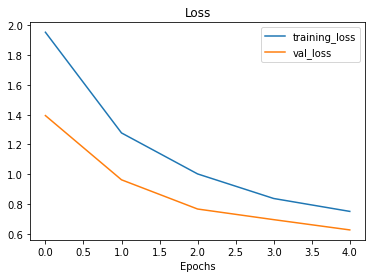

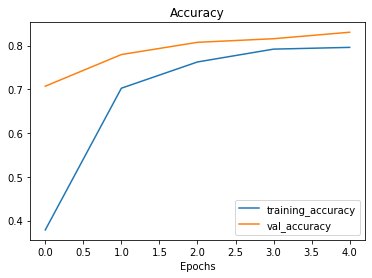

In [99]:
# plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weight

loading in checkpointed weights returns a model to a specific checkpoint

In [100]:
# load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [101]:
# evaluate model_2 with loaded weight
loaded_weight_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6241 - accuracy: 0.8420


In [102]:
# if the results from our previously evaluated model_2 match the loaded weights, everything has worked!
result_10_percent_data_aug == loaded_weight_model_results

False

In [103]:
result_10_percent_data_aug

[0.6240834593772888, 0.8420000076293945]

In [104]:
loaded_weight_model_results

[0.6240832805633545, 0.8420000076293945]

In [105]:
# check to see if loaded model results are very close to our previus non_loaded modeln results
import numpy as np
np.isclose(np.array(result_10_percent_data_aug),np.array(loaded_weight_model_results))

array([ True,  True])

## model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [106]:
# layer in loaded model
model_2.layers

In [107]:
# are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb726363880> True
<keras.engine.sequential.Sequential object at 0x7fb7b09752e0> True
<keras.engine.functional.Functional object at 0x7fb7b0614490> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fb7b05f09d0> True
<keras.layers.core.dense.Dense object at 0x7fb7b09756a0> True


In [108]:
#what layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 tf.math.truediv_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [109]:
# how many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [110]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# freez all layers except  for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


> 🔑 **Note:** when using fine-tuning it's best practice to lower your learning rate by some amount.  how much? this is a hyperparameter you can tune.but a good rule of thumb is at least 10x (though different sorcues will claim other value )

In [111]:
#check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 tf.math.truediv_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [112]:
# now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [113]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately
     

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221216-074829
Epoch 5/10
24/24 [==============================] - 15s 375ms/step - loss: 0.7040 - accuracy: 0.7613 - val_loss: 0.4983 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 7s 302ms/step - loss: 0.3564 - accuracy: 0.8933 - val_loss: 0.4832 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 9s 361ms/step - loss: 0.2472 - accuracy: 0.9213 - val_loss: 0.4916 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 9s 349ms/step - loss: 0.1332 - accuracy: 0.9667 - val_loss: 0.4855 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 8s 326ms/step - loss: 0.1277 - accuracy: 0.9560 - val_loss: 0.5558 - val_accuracy: 0.8191
Epoch 10/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0904 - accuracy: 0.9760 - val_loss: 0.6445 - val_accuracy: 0.8158


In [114]:
# evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 55 epochs)
result_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6378 - accuracy: 0.8280


the `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of rinning `fit()` with another (e.g before and after fine-tunning).

In [115]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3786666691303253, 0.7026666402816772, 0.762666642665863, 0.7919999957084656, 0.7960000038146973, 0.7613333463668823, 0.8933333158493042, 0.9213333129882812, 0.9666666388511658, 0.9559999704360962, 0.9760000109672546]


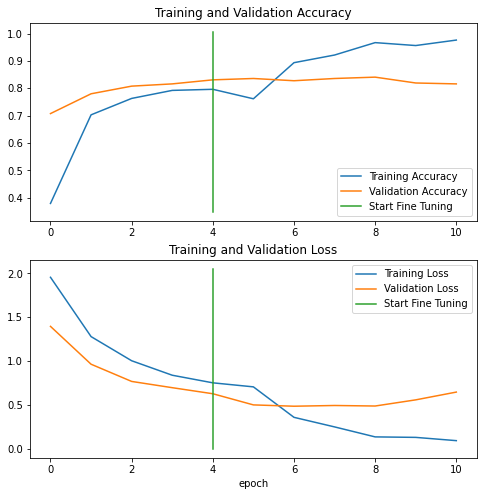

In [116]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## Model 3: Fine-tuning and existing model on all of the data

In [117]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-12-16 07:49:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 142.250.81.208, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  39.2MB/s    in 11s     

2022-12-16 07:49:52 (44.7 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [118]:
# setup training and test dir 
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data"

In [119]:
# how many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [132]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
     

Found 750 files belonging to 10 classes.
Found 10000 files belonging to 2 classes.


the best dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this ...

In [133]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
#model_2.evaluate(test_data)
     

In [134]:
result_fine_tune_10_percent

[0.6378272175788879, 0.828000009059906]

to train a fine-tuning model (model_4) we need to revert model_2 back to this featrue extracyion weight

In [135]:
#load model from checkpoint, that way we can fine-tine from
# the same stage the 10 precent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [136]:
# let's evaluate model_2 now 


Alright, the previous steps might seem quite confusing but all we've done is:

1. training a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.

2. Fine-tuning the same model on the same 10% of the datat for a futher 5 epochs with the tpo 10 layer of the base model unfrozen.

3. saved the result and training logs each time

4. reloaded the model from 1 to do the same steps as 2 but with all of the data(model_4).

In [137]:
# check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
 print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [138]:
# let's drill into our base_model (efficientnetbo) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 tf.math.truediv_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [139]:
# compile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [140]:
# Continue to train and fine-tune the model to our data
#fine_tune_epochs = initial_epochs + 5
'''
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])
   '''  

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221216-081125
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.8293

ValueError: ignored

## viewing our experiment data on TensorBoard
> 🔑 *Note: * Anything you upload to TensorBoard.dev is going to be public .so if youo have private data , do not upload.


In [142]:
#view tensorboard logs of transfer learning modelling experiments (should ~4 models)
#upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Treansfer learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amount o"\
  --one_shot # exits the uploader once its  finished uploaded


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=0VakznfQLGmgKYv1czhK2DYtoDDFV7&prompt=consent&access_type=o

In [143]:
#view 
!tensorboard dev list

https://tensorboard.dev/experiment/MDQp6omxQVasM7zhAaMFwg/
	Name                 Treansfer learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount o
	Id                   MDQp6omxQVasM7zhAaMFwg
	Created              2022-12-16 08:25:01 (6 minutes ago)
	Updated              2022-12-16 08:25:12 (5 minutes ago)
	Runs                 18
	Tags                 5
	Scalars              252
	Tensor bytes         0
	Binary object bytes  8741547
https://tensorboard.dev/experiment/6pwHjnw3QpKV7Knf159S2A/
	Name                 efficientnetB0 vs. Resnet50v2
	Description          comparing two fifferent TF Hub feature extraction model architecture
	Id                   6pwHjnw3QpKV7Knf159S2A
	Created              2022-11-21 12:12:51
	Updated              2022-11-21 12:12:58
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7768382
Total: 2 experiment(

In [ ]:
# to delete an experiment
#!tensorboard dev delete --experiment_id MDQp6omxQVasM7zhAaMFwg